In [30]:
## 20230519 NF/FF Flights with fixed pulsing cadence over WLC... (use WLC Site!)
## Group 1: ch0=Bicolog, ch1=Telescope_Y_NSpol
    ## 'FLY779.csv' - Altitude ~100m, Yaw ~0deg  --> FFNS
    ## 'FLY780.csv' - Altitude ~20m, Yaw ~0deg   --> NFNS20
    ## 'FLY781.csv' - Altitude ~18m, Yaw ~0deg   --> NFNS18
## Group 2: ch0=Telescope_X_EWpol, ch1=Bicolog
    ## 'FLY782.csv' - Altitude ~18m, Yaw ~90deg  --> NFEW18
    ## 'FLY783.csv' - Altitude ~20m, Yaw ~90deg  --> NFEW20
    ## 'FLY784.csv' - Altitude ~100m, Yaw ~90deg --> FFEW
    
## Changelog/Bug hunting notes:
# Solved timing bugs from clockless correlator operation:
    #1) recreated time axis from fpga_counts
    #2) changed WLC site read options to remove factor of 1e-9 on t0

##From loadD3Adata_Dallas.py:
from matplotlib.pyplot import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
import numpy as np
import h5py
##From WT:
import datetime
import pytz
import os
import glob
from matplotlib import colors
import pandas
import csv
import pickle
%matplotlib inline
import beamcals
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
from beamcals import beammap
from beamcals import reduce_ccclass
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
import beamcals.reduce_ccclass as rc
from beamcals.sites import site
import yaml
from scipy.interpolate import interp1d
from scipy.stats import pearsonr
gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')

fitdir='/hirax/GBO_Analysis_Outputs/main_beam_fits/'
ymldir = '/hirax/GBO_Analysis_Outputs/concat_config_files/'
pckldir = '/hirax/GBO_Analysis_Outputs/flight_pickles/'
ampdir = '/hirax/GBO_Analysis_Outputs/amplitude_corrections/'
beamdir = '/hirax/GBO_Analysis_Outputs/beam_pickles/'


# Display settings:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [23]:
fly='533'
fly='618'

with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]

for fi in range(0,len(documents["flight_info"]["flights"])):
    if fly == flights[fi]: f = fi
print(f, 'FLIGHT: ', documents["flight_info"]["flights"][f])

fly = flights[f]
dtub = documents["flight_info"]["tubs"][f]
dtlb = documents["flight_info"]["tlbs"][f]
cdat = documents["flight_info"]["cdats"][f]
tclb = documents["flight_info"]["tclbs"][f]
tcub = documents["flight_info"]["tcubs"][f]
fmax = documents["flight_info"]["fmaxes"][f]

print(fly,dtlb,dtub,cdat,tclb,tcub,fmax)


4 FLIGHT:  618
618 7300 15000 20211021T183430Z 8500 20000 None


Initializing drone data via datcon_csv routine: FLY618.csv
  --> Skipping rows 1 to 7799 to eliminate NAN values
  --> Attempting to load position data from RTK
    --> RTK data contains 0/7700 non-nan values
    --> RTK Data not usable for this data file...
  --> Loading position data from GPS(0) instead:
Timestamp interpolation succeeded
  --> generating llh, geocentric cartesian, local cartesian, and local spherical coordinates.
  --> generating dish and receiver line of sight coordinates.
plotting drone coordinates for all time samples:
overplotting drone coordinates for t_cut samples: [0:-1]


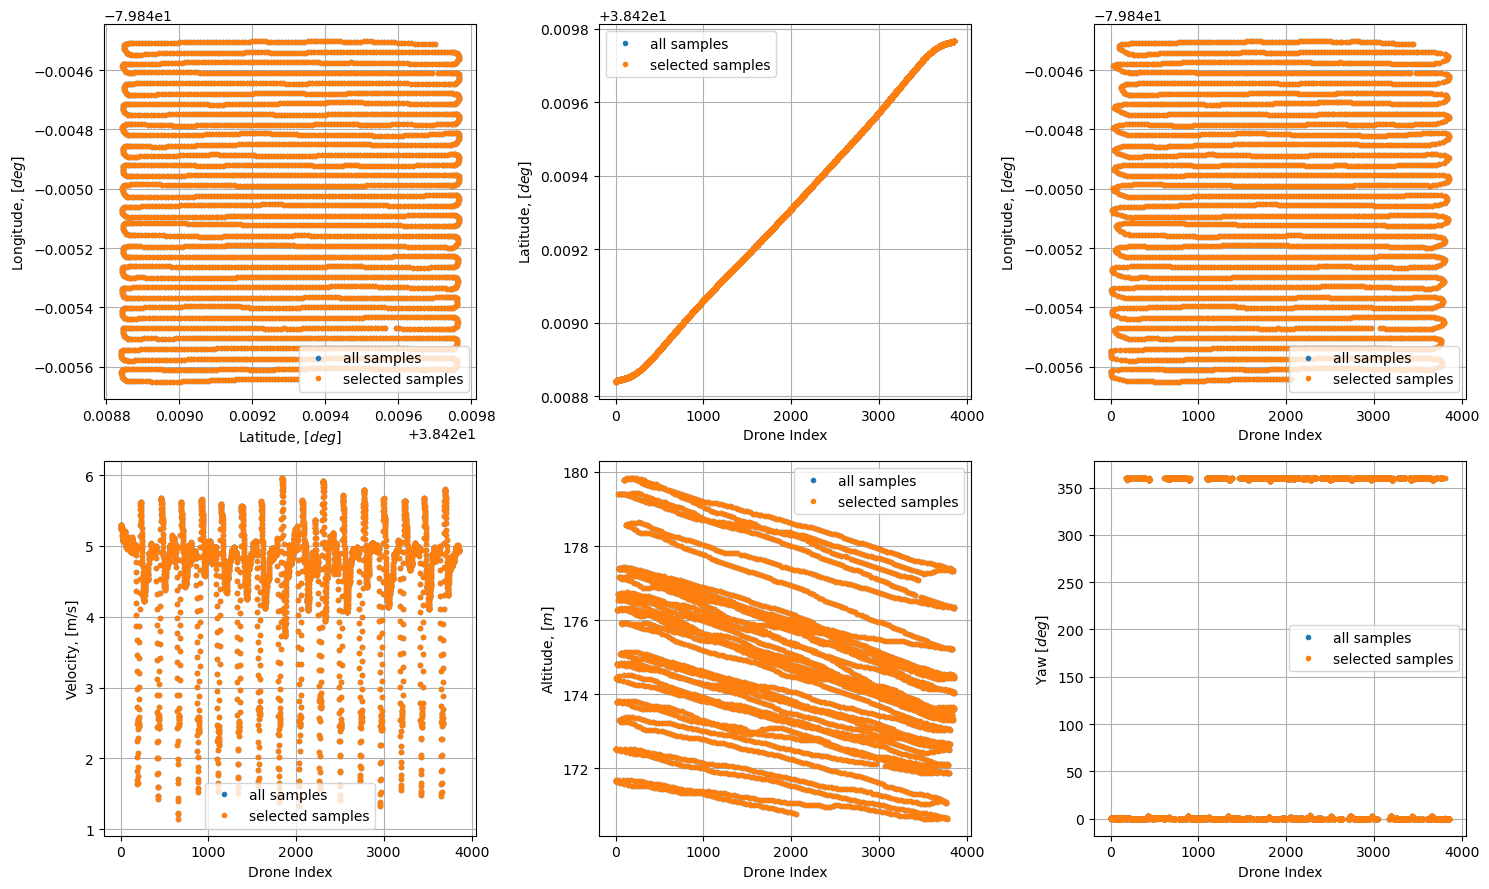

In [26]:
# Flight 1: 'FLY533.csv' 
dronedir='/hirax/all_drone_data/datcon_csv/'
f533drone=drone.Drone_Data(Drone_Directory=dronedir,FLYTAG='FLY'+fly+'.csv',site_class=gbosite,tlb=dtlb,tub=dtub)
pu.Plot_Drone_Coordinates(f533drone)

In [4]:
## FLY533:
# datadir='/hirax/GBO_Aug_2021/TONE_ACQ/20210826T182904Z_yale_drone/corr/20210826T182915Z/'
# gaindir='/hirax/GBO_Aug_2021/TONE_ACQ/digital_gains/20210826T182904Z_yale_drone_yale_digitalgain/'
# f533corr=corr.Corr_Data(Data_Directory=datadir,Gain_Directory=gaindir,site_class=gbosite,crossmap=[])

## FLY618:
datadir='/hirax/GBO_Oct_2021/TONE_ACQ/20211021T183430Z_yale_drone/corr/20211021T183443Z/'
gaindir='/hirax/GBO_Oct_2021/TONE_ACQ/digital_gains/20211021T183430Z_yale_drone_yale_digitalgain/'
f533corr=corr.Corr_Data(Data_Directory=datadir,Gain_Directory=gaindir,site_class=gbosite,crossmap=[])


Initializing Correlator Class using:
  --> /hirax/GBO_Oct_2021/TONE_ACQ/20211021T183430Z_yale_drone/corr/20211021T183443Z/
  --> Arrays initialized with shape (93, 256, 1024, 16)
Assigning array values by reading in data files:
  --> Loading File: 0092/0092
  --> Finished. Reshaping arrays.


In [17]:
f533concat=concat.CONCAT(CORRDATCLASS=f533corr,DRONEDATCLASS=f533drone,\
                        config_directory="/hirax/GBO_Analysis_Outputs/tynd/concat_config_files/",\
                        output_directory="/hirax/GBO_Analysis_Outputs/tynd/",\
                        load_yaml=False,traceback=True,save_traceback=True)

Initializing CONCAT CLASS with active traceback using:
  --> /hirax/GBO_Oct_2021/TONE_ACQ/20211021T183430Z_yale_drone/corr/20211021T183443Z/
  --> FLY618.csv
Creating directory for saving traceback and analysis outputs:
  --> /hirax/GBO_Analysis_Outputs/tynd/FLY618_20211021T183430Z/
Concat initialized without previous config file...
Interpolating drone coordinates for each correlator timestamp:
  --> correlator timestamp axis contains 9220 elements
  --> drone timestamp axis contains 3858 elements


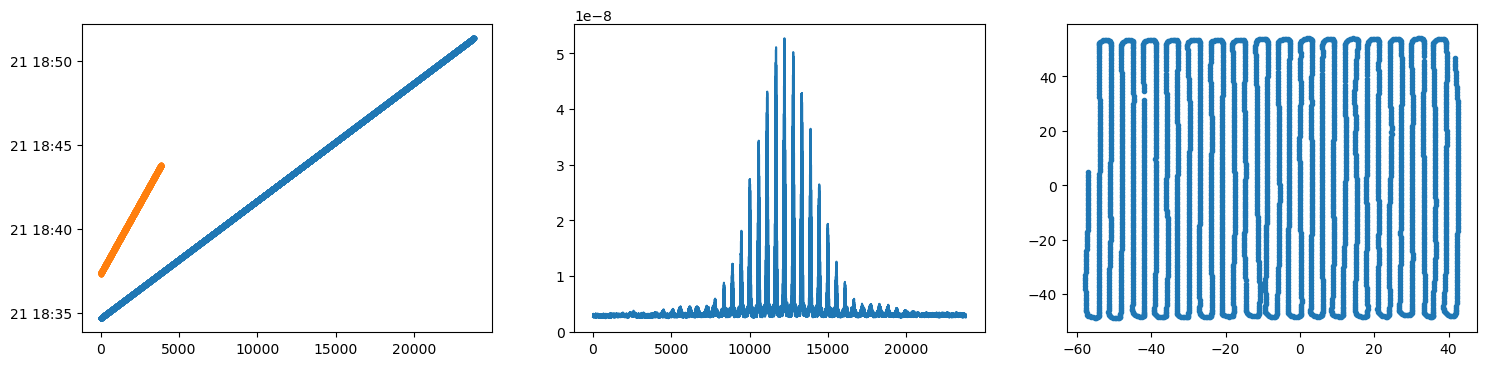

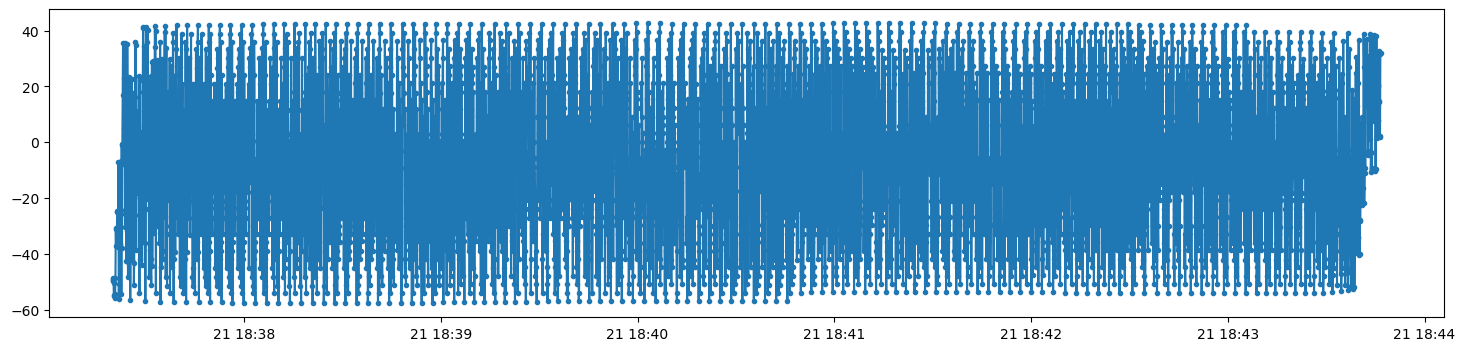

In [53]:
fig,[ax1,ax2,ax3]=subplots(nrows=1,ncols=3,figsize=(18,4))
ax1.plot(f533corr.t_arr_datetime,'.')
ax1.plot(f533drone.t_arr_datetime,'.')
ax2.plot(f533corr.V[:,900,1])
ax3.plot(f533drone.coords_xyz_LC[:,0],f533drone.coords_xyz_LC[:,1],'.')

figure(figsize=(18,4))
plot(f533drone.t_arr_datetime,f533drone.coords_xyz_LC[:,0],'.-')
#plot(f533corr.t_arr_datetime[:],f533corr.V[:,900,1])

/home/tyndall/anaconda3/lib/python3.8/site-packages/beamcals/concat.py:230: RuntimeWarning: invalid value encountered in divide
  normminsubdata=minsubdata/np.percentile(minsubdata,minmaxpercents[1])
/home/tyndall/anaconda3/lib/python3.8/site-packages/beamcals/concat.py:247: RuntimeWarning: All-NaN slice encountered
  maxPrind=np.where(Pr_arr[i,:]==np.nanmax(Pr_arr[i,:]))[0][0]


Maximum Pearson_R Correlations between data and square wave function:
  --> t_indices = [74. 80. 84. 80. nan nan 85. 80. 80. 81. 84. 80. 81. nan 71. 81.]
  --> t_deltas = [-0.326 -0.32  -0.316 -0.32     nan    nan -0.315 -0.32  -0.32  -0.319
 -0.316 -0.32  -0.319    nan -0.329 -0.319]
Selecting square wave function time offset:
  --> t_delta_pulse = -0.3200000000
Finding relevant pulsing indices and checking for overlaps:
  --> on/off ind intersection: []
  --> on/span ind intersection: []
  --> off/span ind intersection: []


/home/tyndall/anaconda3/lib/python3.8/site-packages/beamcals/concat.py:304: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_xlim(self.t_arr_datetime[t_bounds[0]],self.t_arr_datetime[t_bounds[1]])


Calculating background spectra from indices where the noise source is off.
  --> Background subtraction completed using window_size = 5
Synchronizing data from correlator and drone:
  --> Previous t_delta_dji not found
  --> Calculating via 2DGauss fitting routine:


/home/tyndall/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Applying a time correction of -0.25 seconds using Channel 1 fits.
  --> Variable synchronation successful, generating output plots:
  --> Saving output plot.


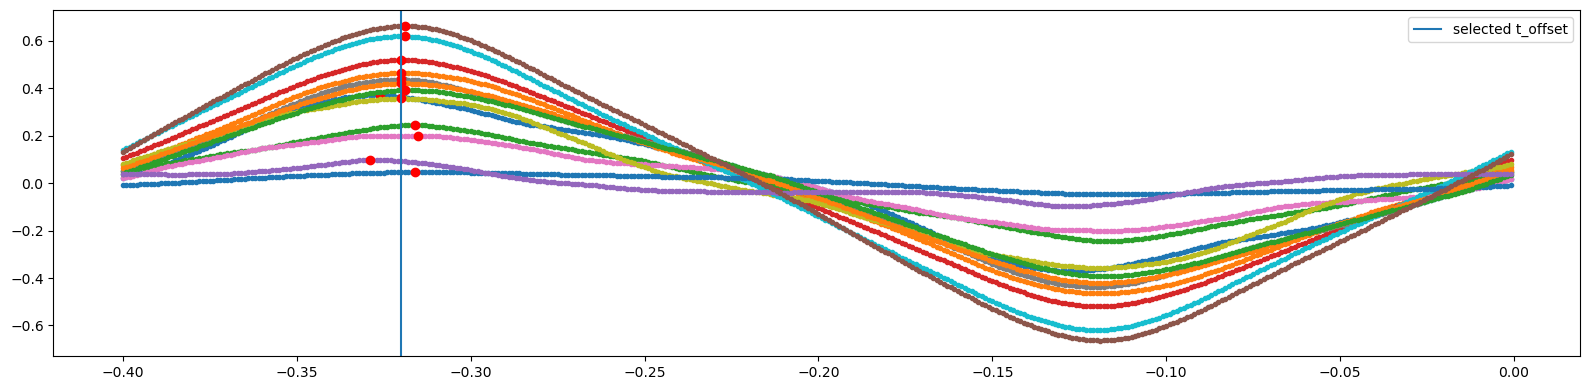

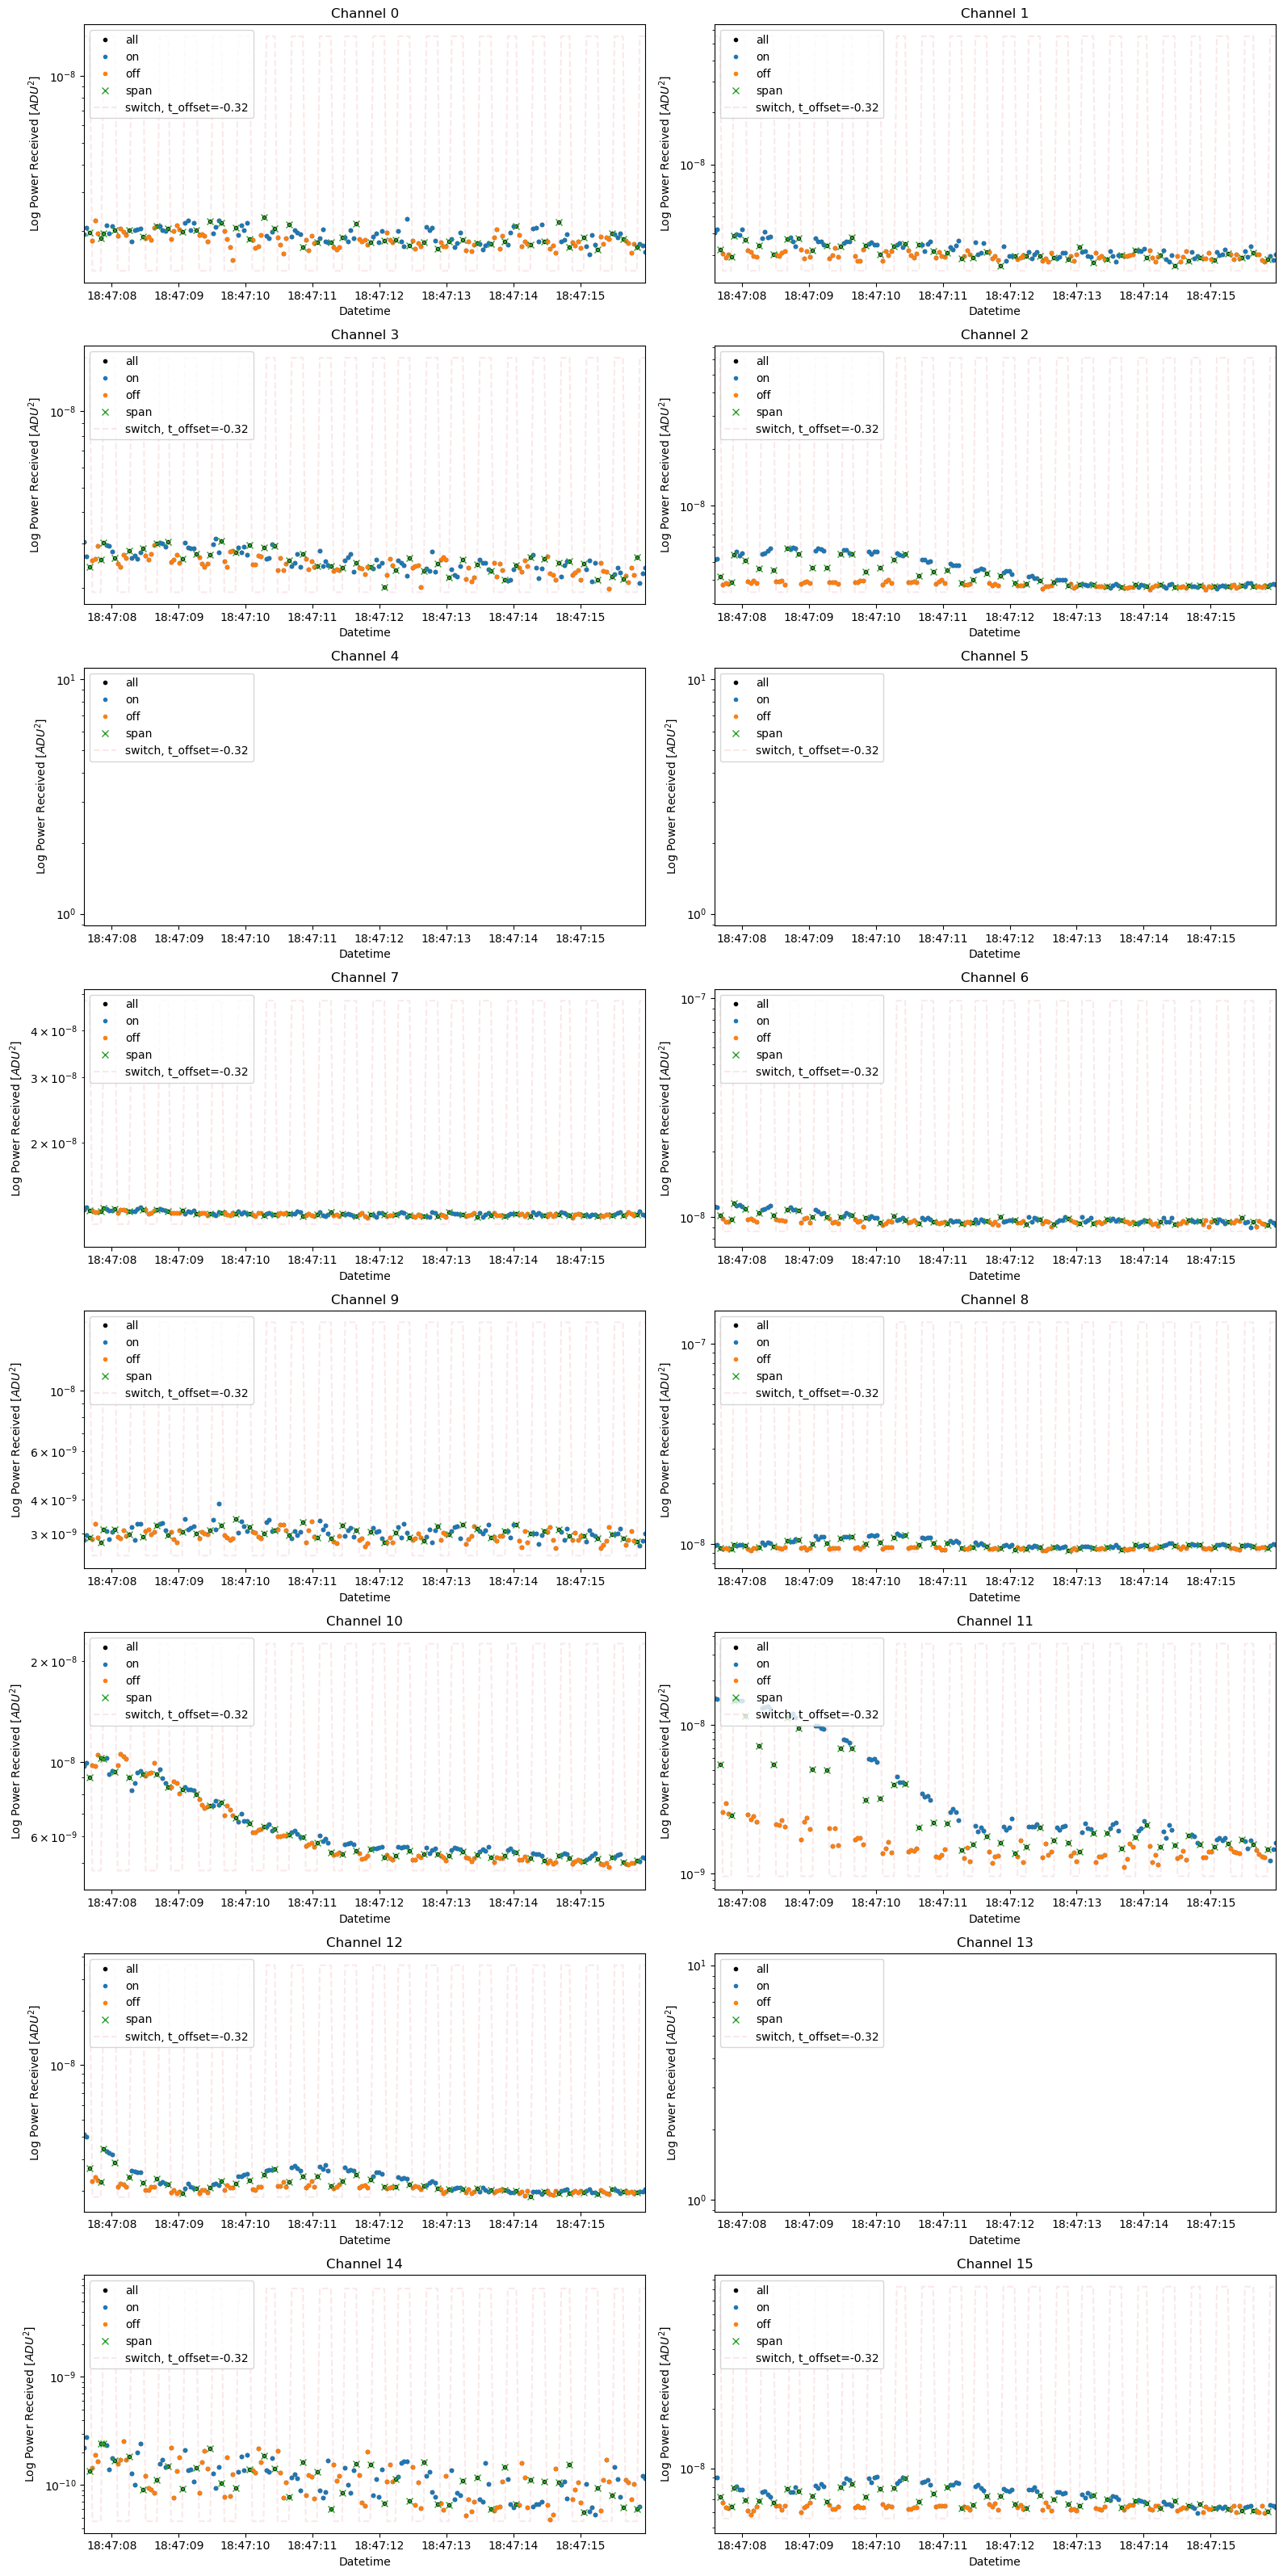

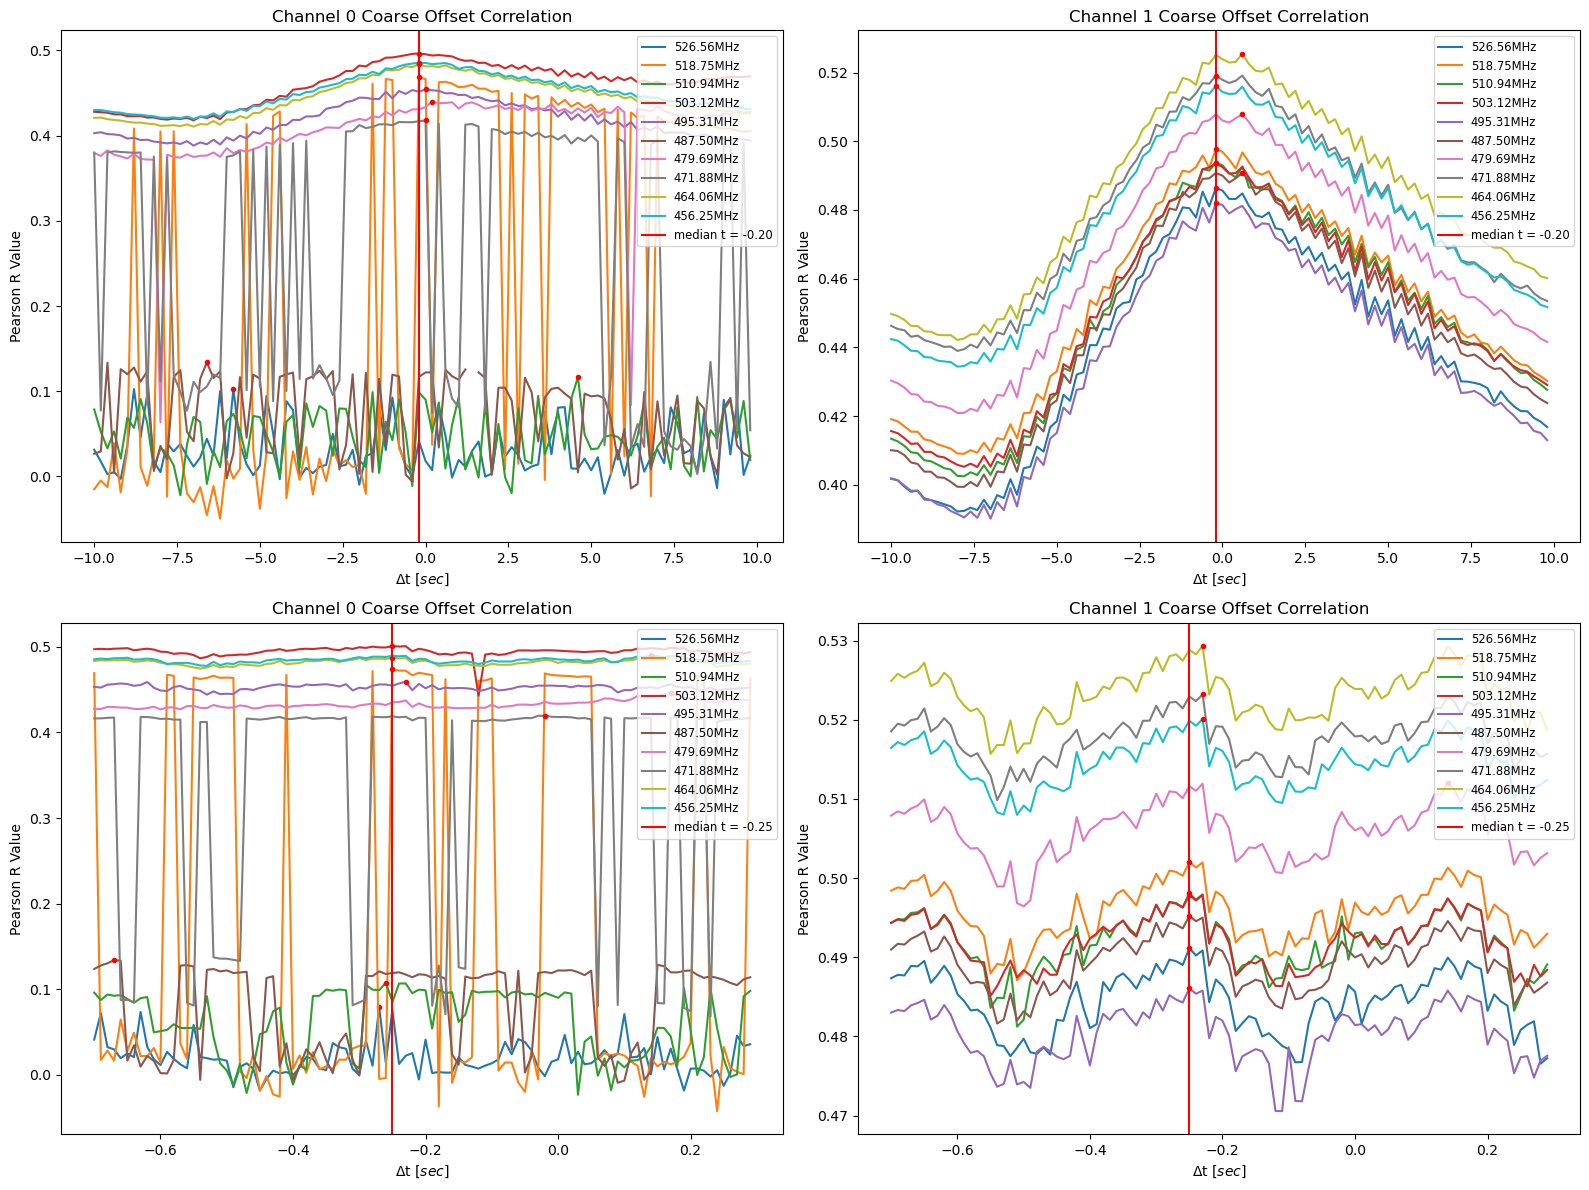

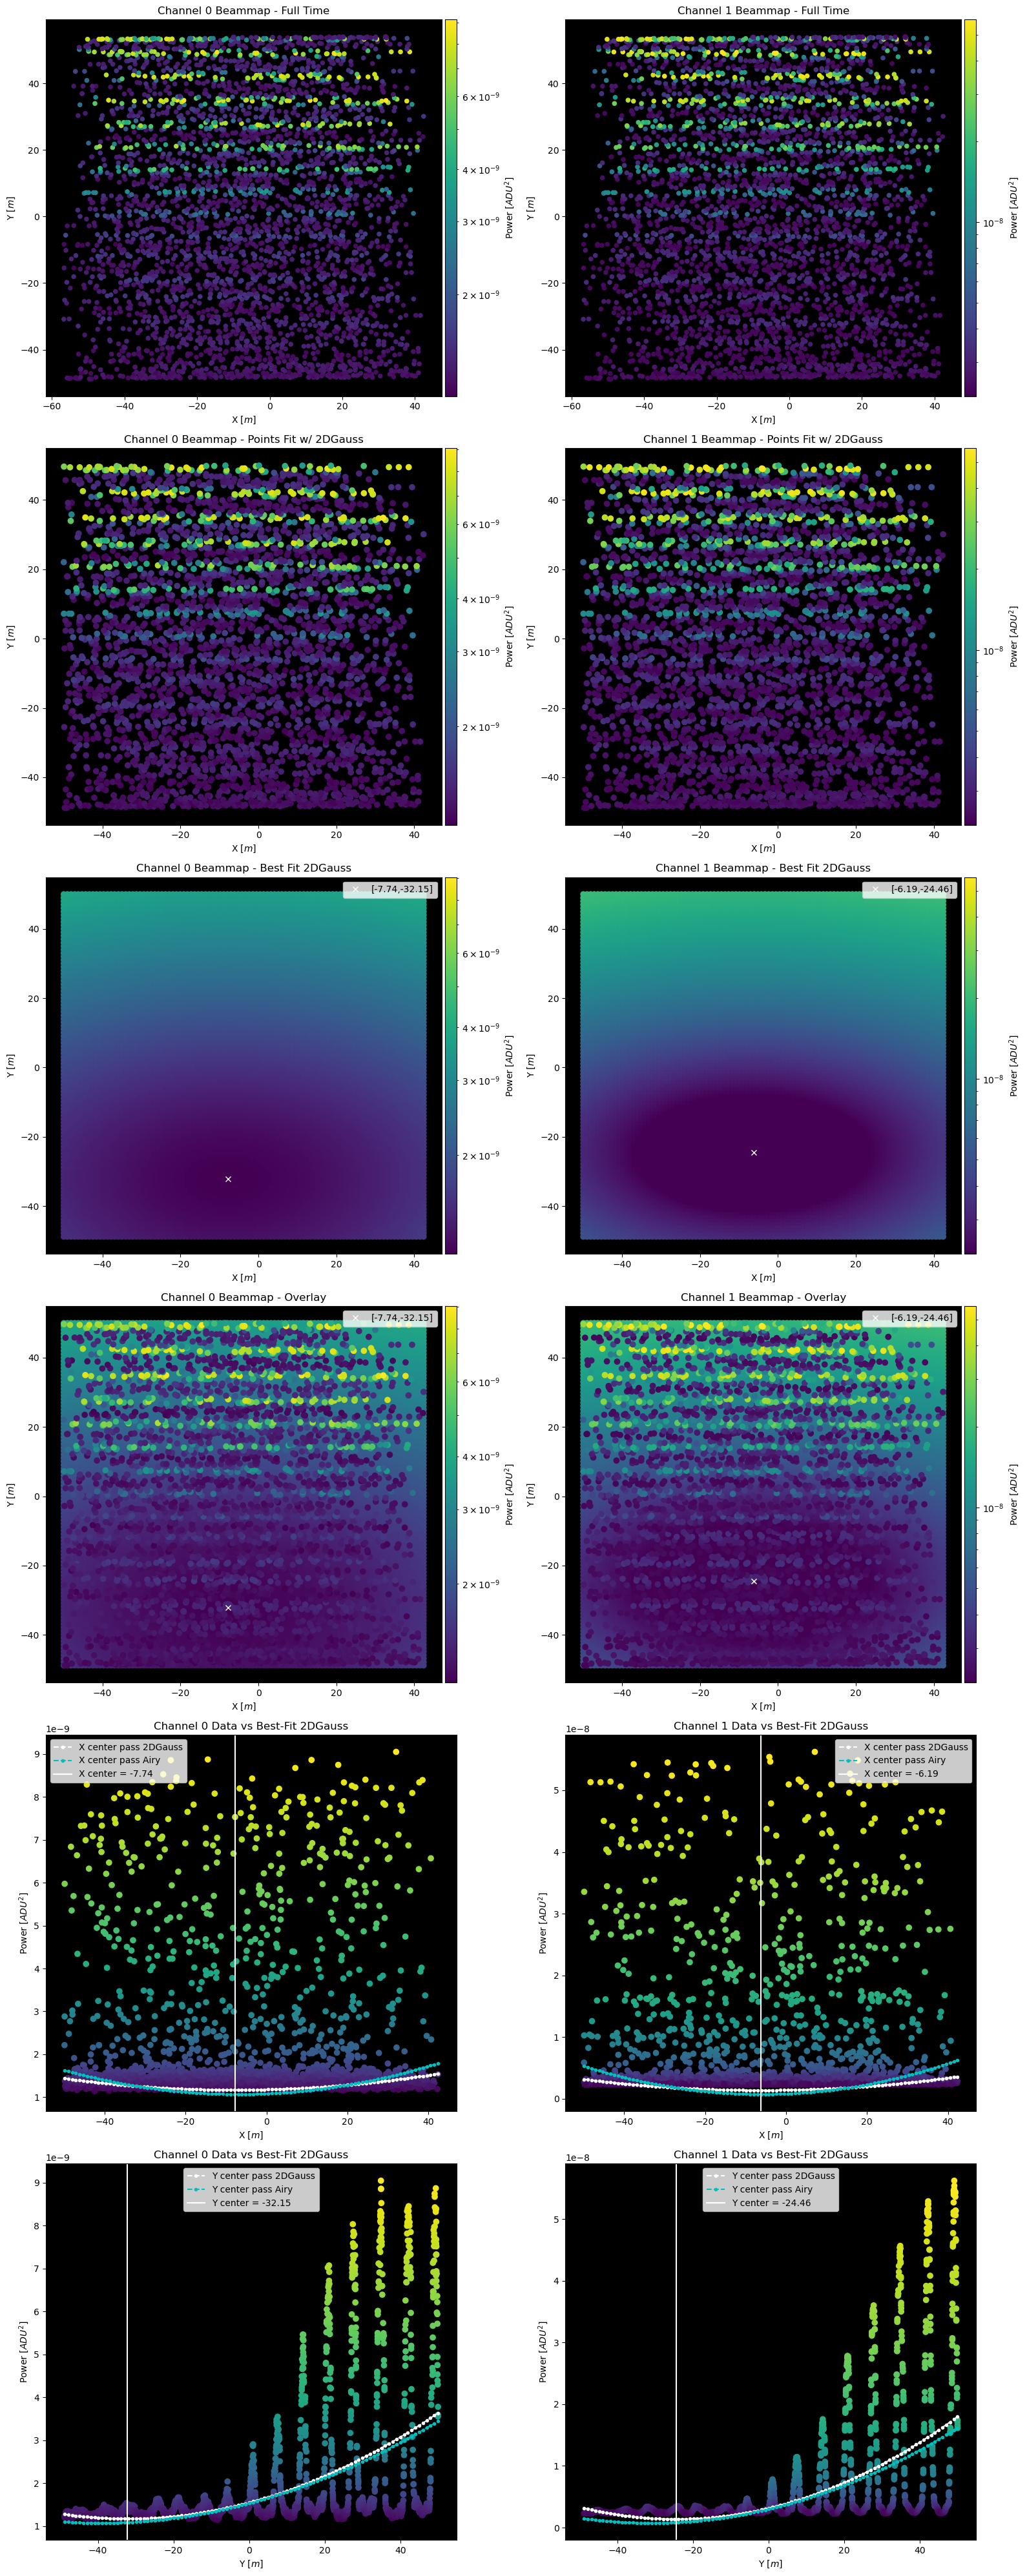

In [8]:
f533concat.Extract_Source_Pulses(Period=400000,Dutycycle=200000,t_bounds=[17800,18000],f_ind=900,minmaxpercents=[10.0,99.0])

f533concat.Perform_Background_Subtraction(window_size=5)
f533concat.Synchronization_Function(inputcorr=f533corr,inputdrone=f533drone,freqs=np.arange(700,900,20),\
                                    FMB_coordbounds=[50.0,50.0,100.0],FMB_ampbound=0.999)

Applying correction to V_bgsub using concat.Distance_Compensation() Function:
  --> Saving output plot.
  --> Complete.


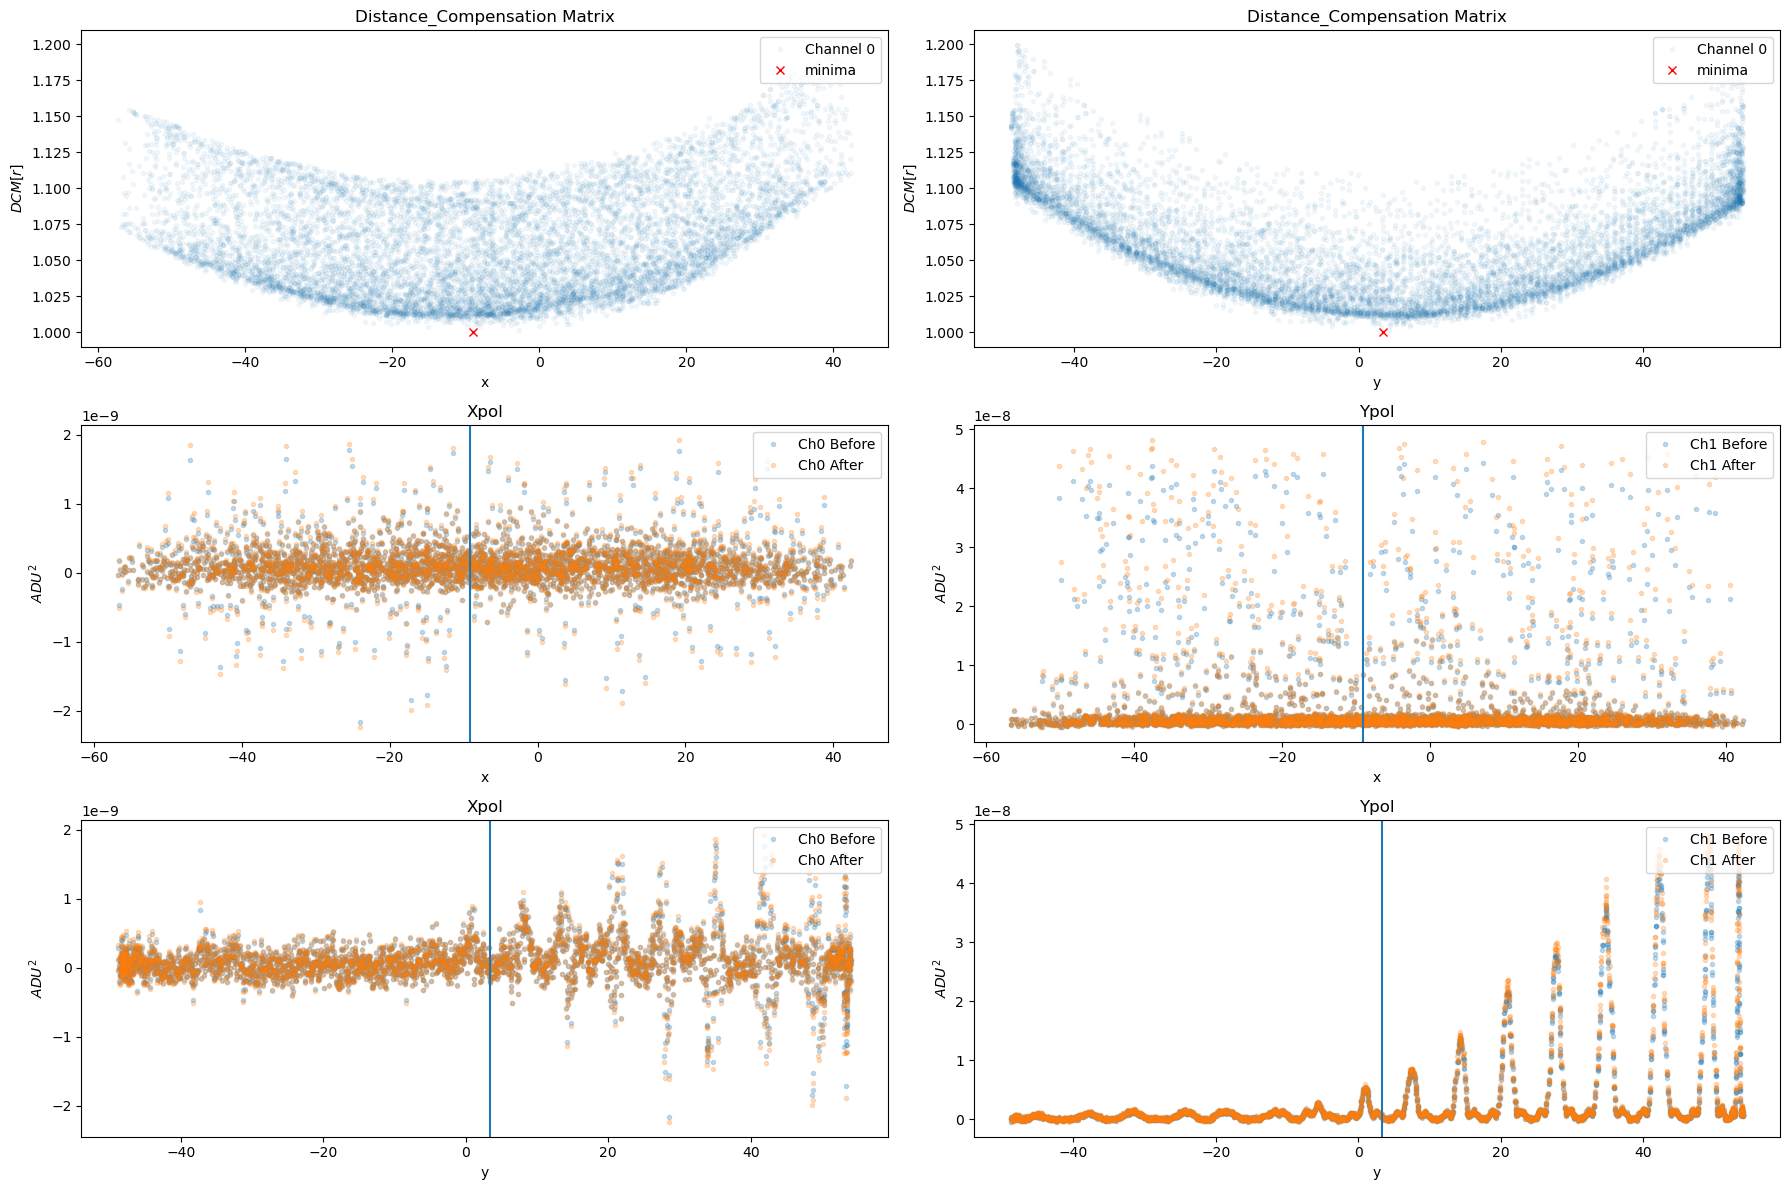

In [9]:
f533concat.Distance_Compensation(f_ind=900,plot_channels=[0])
# f533concat.Main_Beam_Fitting(fit_param_directory="/hirax/GBO_Analysis_Outputs/tynd/main_beam_fits/",Vargs='bgsub',coordbounds=[20,20,15])
# # FFNSconcat.Export_yaml()

# #export pickle for reduced class data for beammap function (include_cross_data=True will save V_cross_bgsub):
# # thingy = rc.Smallify(concatclass=FFNSconcat,pickle_directory="/home/tyndall/Desktop/20230519_WLC_NF2FF_Flights/products/pickles/",include_cross_data=True)
# # print(thingy.tmppath)
# # with open(thingy.tmppath, 'wb') as outp:
# #     pickle.dump(thingy, outp, pickle.HIGHEST_PROTOCOL)
# # print('DONE')


In [7]:
pu.Plot_Beammap(f533concat,t_bounds=[0,-1],f_bounds=[900,901],coord_args='LC',pulse_args='bgsub',cbounds=[1e-12,1e-7])

AttributeError: 'CONCAT' object has no attribute 'V_bgsub'

<Figure size 1600x5600 with 0 Axes>